In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import setproctitle
import dataset
from model import BGCN, BGCN_Info, NGCF, NGCF_Info, BasConv, BasConv_Info, GCN, GCN_Info, RGCN, RGCN_Info, GCNBG, GCNBG_Info, NGCFBG_Info, NGCFBG, DGCF_Info, DGCF, VAE_Info, VAE, DGCF_UBinten_Info, DGCF_UBinten, DGCF_UBinten_v2_Info, DGCF_UBinten_v2, DGCF_Iinten, DGCF_Iinten_Info,DGCF_BIinten, DGCF_BIinten_Info,DGCF_BI3inten, DGCF_BI3inten_Info
from utils import check_overfitting, early_stop, get_perf, logger 
from train import train
from metric import Recall, NDCG, MRR, Precision
from config import CONFIG
from test import test
import loss
import time
import csv

TAG = ''

In [2]:
from torch_sparse import SparseTensor

In [3]:
item_index2id={}
with open('data/inscart/pid.txt', 'r') as f:
    for l in f.readlines():
        if len(l) == 0: break
        l = l.strip('\n')
        ids = [i for i in l.split(' ')]
        index, itemid = ids[0], ids[1]
        item_index2id[int(index)]=int(itemid[2:])
import pandas as pd
table = pd.read_csv ('instacart/products.csv')
itemid2name={}
for (itemid, name) in zip(table['product_id'], table['product_name']):
    itemid2name[itemid]=name

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = CONFIG['gpu_id']
device = torch.device('cuda')
user_train_data, bundle_train_data, bundle_test_data, ui_graph, assist_data = \
            dataset.get_dataset(CONFIG['path'], CONFIG['dataset_name'], task=CONFIG['task'])
    # u-b-train, b-i-train, b-i-test
test_loader = DataLoader(bundle_test_data, 2048
                             , False,
                             num_workers=32, pin_memory=True)
ub_graph = user_train_data.ground_truth_u_b
bi_graph = bundle_train_data.ground_truth_b_i
ui_graph = ui_graph
#  metric

>>>>>>>>>>U-B statistics in train>>>>>>>>>>
interactions 3081.0
Average interactions 1.8925061225891113
Non-zero rows 1.0
Non-zero columns 1.0
Matrix density 0.0006142506142506142
finish loading bundle train data
>>>>>>>>>>B-I statistics in train>>>>>>>>>>
interactions 146015.0
Average interactions 47.39208221435547
Non-zero rows 1.0
Non-zero columns 0.8863000931966449
Matrix density 0.0023246225777871347
finish loading bundle train data
>>>>>>>>>>B-I statistics in test>>>>>>>>>>
interactions 34394.0
Average interactions 11.16325855255127
Non-zero rows 1.0
Non-zero columns 0.5642321086967185
Matrix density 0.0005475675029305942
finish loading bundle test data


/home/zhaosen/anaconda3/envs/QGGA/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
metrics = [Recall(5), NDCG(5), Recall(10), NDCG(10), Recall(20), NDCG(20), Recall(40), NDCG(40), Recall(80), NDCG(80)]

In [6]:
CONFIG['test']

['log/NetEase/DGCF_UBinten_v2_tune/08-14-15-03-52-some_note']

In [7]:
DIR='log/inscart/DGCF_UBinten_v2_tune/03-10-11-46-22-some_note'
with open(os.path.join(DIR, 'model.csv'), 'r') as f:
    d = csv.DictReader(f)
    d = [line for line in d]

In [8]:
graph = [ub_graph, ui_graph, bi_graph]
info = DGCF_UBinten_v2_Info(64, 1e-7, 0.3, 0, 1)
model =DGCF_UBinten_v2(info, assist_data, graph, device, pretrain=None).to(device)

finish generating bi, ui graph
finish generating non-atom graph


In [9]:
model.load_state_dict(torch.load(os.path.join(DIR, "1_0d25d9_Recall@20.pth")))

<All keys matched successfully>

In [10]:
from test import test 
test(model, test_loader, device, CONFIG, metrics)

Test: time=5s
Recall@5:0.024334569211054143	NDCG@5:0.05729923415439386	Recall@10:0.04334344712219931	NDCG@10:0.052312034401403	Recall@20:0.07207878283655748	NDCG@20:0.06519983496537499	Recall@40:0.1177071927623755	NDCG@40:0.0865248296602095	Recall@80:0.17956706402712694	NDCG@80:0.11076611274637521	


In [11]:
model.n_factors

4

In [12]:
model.eval()
with torch.no_grad():
    rs = model.propagate()

In [13]:
ui_avalues=model.ui_avalues.to('cpu')

In [14]:
all_h_list = torch.tensor(model.ui_graph_h, dtype=torch.long)
all_t_list = torch.tensor(model.ui_graph_t, dtype=torch.long)

In [15]:
ui_avalues.shape

torch.Size([4, 102223])

In [16]:
avalues_dense=[SparseTensor(row=all_h_list, col=all_t_list, value=ui_avalues[i],sparse_sizes=(model.num_users, model.num_items)).to_dense() for i in range(4)]

In [17]:
avalues_dense=torch.stack(avalues_dense, dim=2)

In [18]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# Importing seaborn to make nice plots.
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
# An user defined function to create scatter plot of vectors
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 4))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=120,
                    c=palette[colors.astype(np.int)])
    plt.xlim(x.min()*1.1, x.max()*1.1)
    plt.ylim(x.min()*1.1, x.max()*1.1)
    #ax.axis('off')
    #ax.axis('tight')

    # We add the labels for each cluster.
    """"
    txts = []
    for i in range(4):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=50)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    """
    return f, ax, sc

In [19]:
users=model.ui_user_feature.to('cpu')
items=model.ui_item_feature.to('cpu')

In [20]:
users.shape

torch.Size([1628, 64])

In [21]:
items.shape

torch.Size([20387, 64])

In [22]:
avalues_dense.shape

torch.Size([1628, 20387, 4])

In [23]:
all_t_list[[all_h_list==47]]

tensor([ 5504,  8198,  6664, 11656,    10, 18187, 10637, 17807, 13841, 16916,
         7702, 12953, 18463, 13728,   800, 18848, 11558,  4776,  5801, 12332,
         5813, 16312, 14778,    60, 10429,  4925, 19774,  1089,  4291,  5444,
        15683, 19276,  1618,  7764, 10069,  9812,  1495, 14427, 19165,  1246,
        12129, 13282, 15842, 19561,  1133, 16626,  2548,  4348,  7166, 18729,
        12149,  2716,  6336,  6084])

KeyboardInterrupt: 

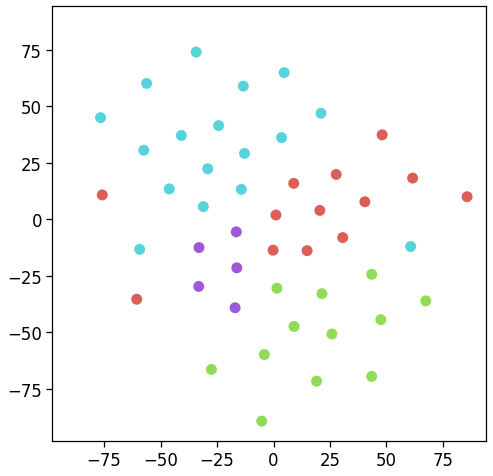

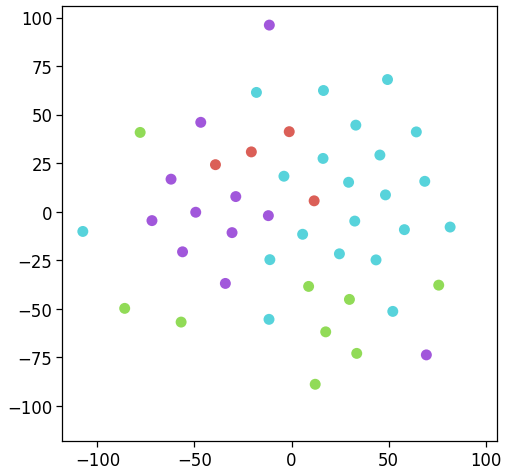

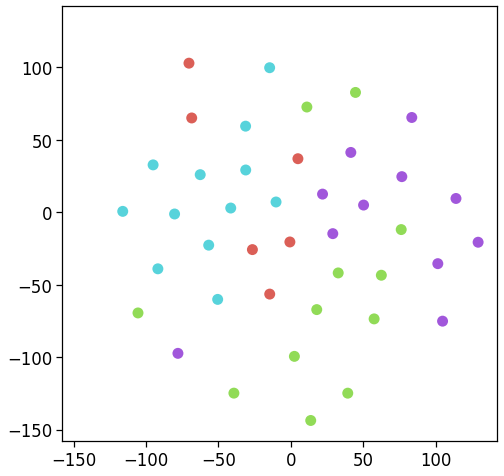

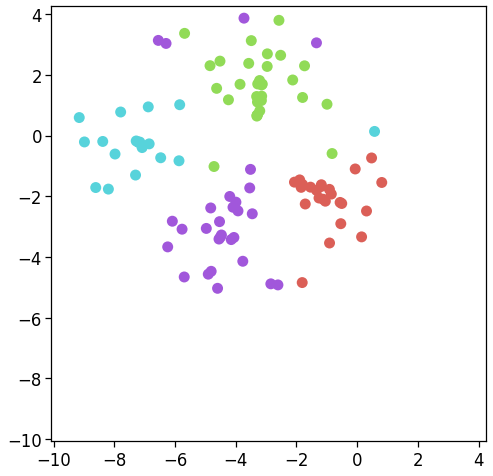

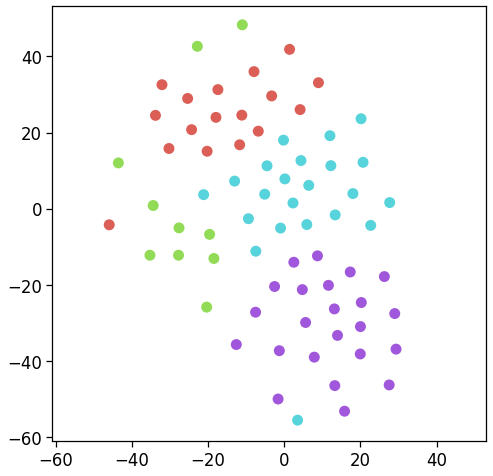

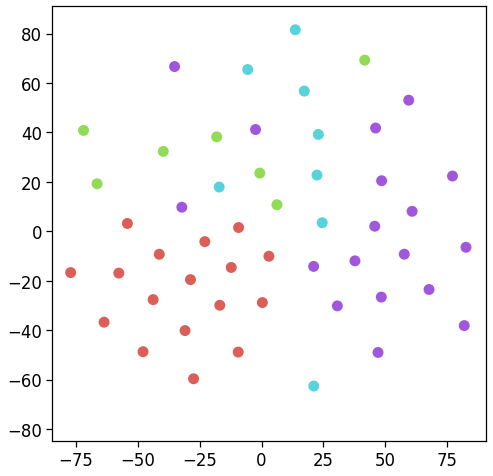

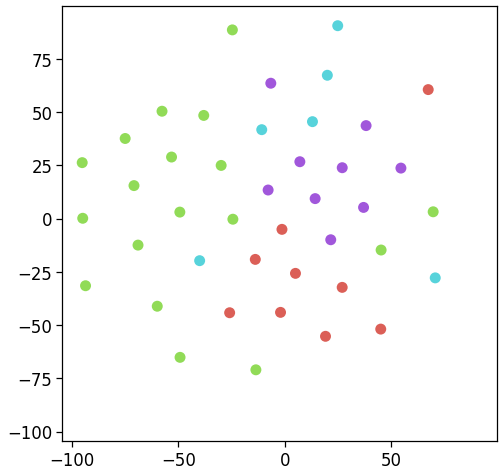

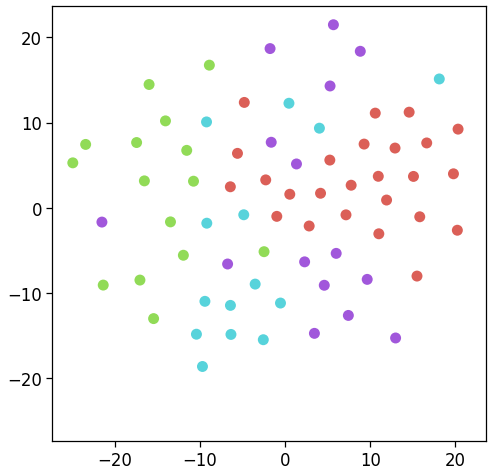

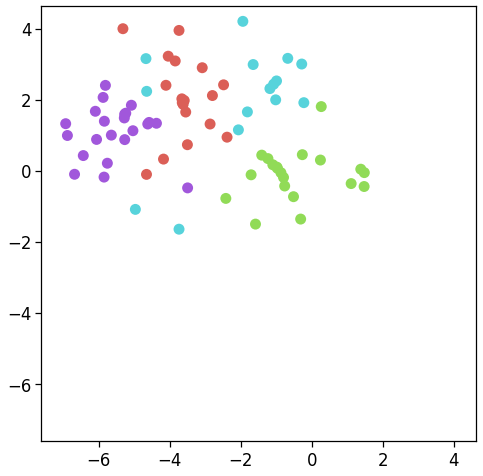

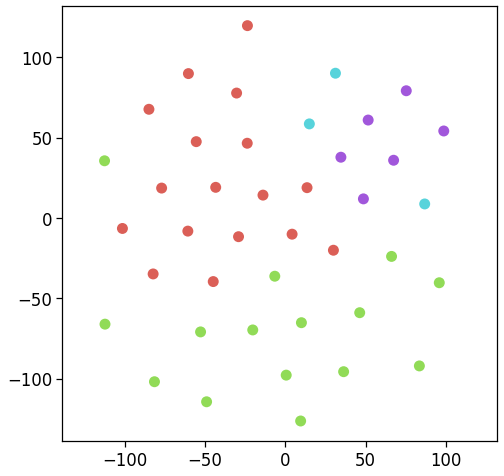

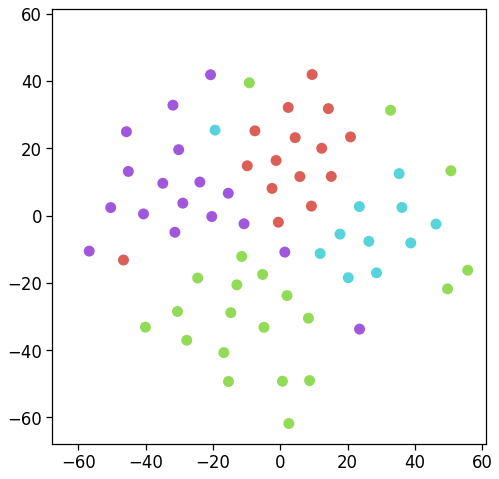

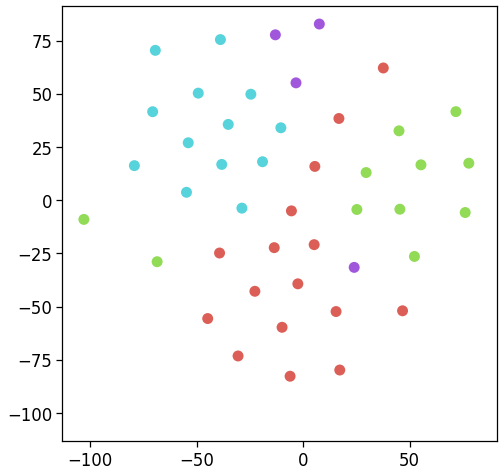

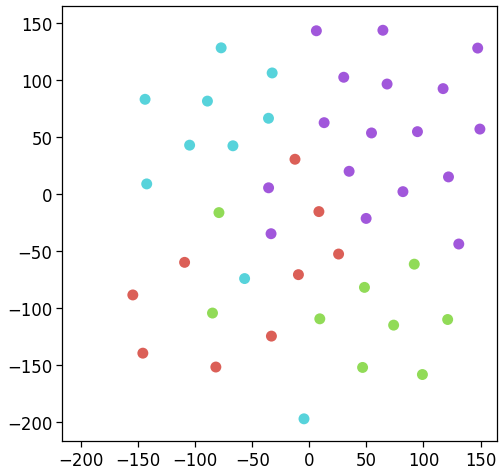

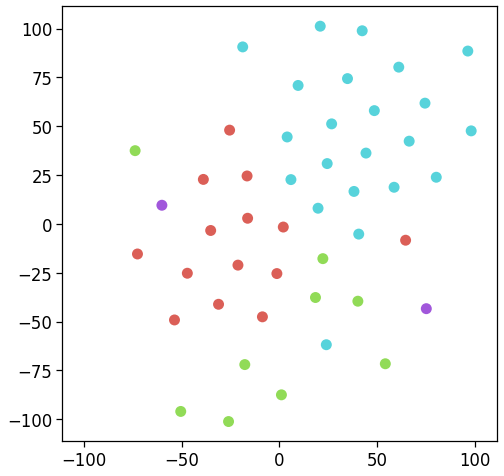

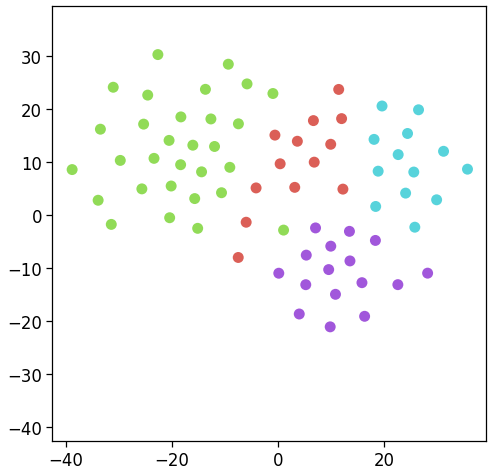

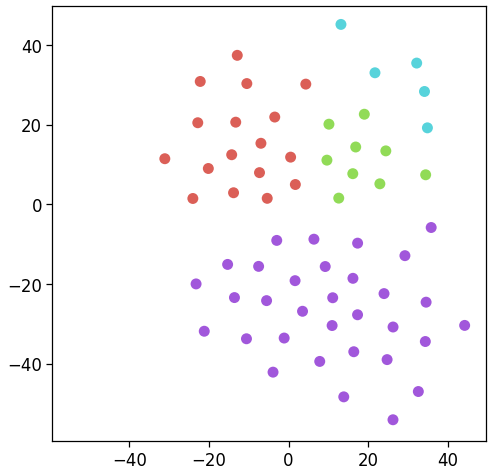

In [24]:
for i in range(users.shape[0]):
    dis=avalues_dense[all_h_list[all_h_list==i],all_t_list[[all_h_list==i]],:].max(1)[1]
    users_45=users[i]
    u45_items=items[all_t_list[[all_h_list==i]]]
    u45_items=torch.stack([u45_items[i,dis[i]*16:dis[i]*16+16] for i in range(u45_items.shape[0])])
    item_embedded = TSNE(n_components=2).fit_transform(u45_items)
#sns.palplot(np.array(sns.color_palette("hls", 4)))
    f, ax, sc=scatter(item_embedded, dis.numpy())
    #f.savefig('pic/user/'+str(i)+'.png', dpi=100)

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x7f6e9b896d30>)

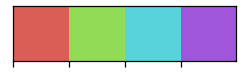

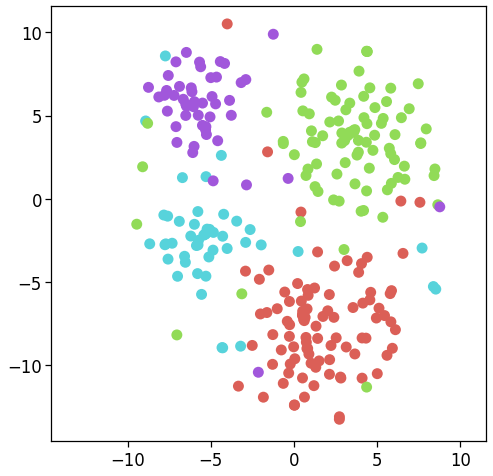

In [44]:
dis=avalues_dense[all_h_list[all_h_list==21],all_t_list[[all_h_list==21]],:].max(1)[1]
users_45=users[21]
u45_items=items[all_t_list[[all_h_list==21]]]
u45_items=torch.stack([u45_items[i,dis[i]*16:dis[i]*16+16] for i in range(u45_items.shape[0])])
item_embedded = TSNE(n_components=2).fit_transform(u45_items)
sns.palplot(np.array(sns.color_palette("hls", 4)))
scatter(item_embedded, dis.numpy())

In [45]:
for i in range(4):
    print(i)
    for item in all_t_list[[all_h_list==21]][dis==i]:
        print(itemid2name[item_index2id[int(item.numpy())]])

0
YoBaby Blueberry Apple Yogurt
Non-Scratch Scrub Sponges
Organic Pears, Peas and Broccoli Puree Stage 1
Swaddlers Size 2 Diapers
Coke Zero Diet Soda
Whole Wheat Crackers
Canadian Bacon, Uncured
Lemon-Lime Soda
Dinner Plates
Squared Cups
Hazelnut Medium Roast K-Cup Packs Arabica Coffee
Organic 1% Milk
Spinach Peas & Pear Stage 2 Baby Food
Cut Crystal Plastic Cups
Baby Food Stage 2 Pumpkin Banana
Pacific Cooler Juice Drink
Milano Double Chocolate Cookies
Prime Fillet Solid White Albacore in Water
Dark Chocolate Fudge Stripe
ZBar Organic Chocolate Brownie Energy Snack
Bagel Bites Three Cheese Mini Bagel Pizzas
Uncrustables Reduced Sugar Peanut Butter & Grape Soft Bread Sandwiches
Banana
Original Chocolate Pudding Snacks
Kettle Cooked Sea Salt & Vinegar Potato Chips
Cinnamon Brown Sugar Breakfast Biscuits
Toilet Bowl Cleaner with Bleach Rain Clean
Baked Cheese Puffs Real Cheddar Lunch Packs
Creamy & Raw Almond Butter
Dishwasher Detergent, Fresh Scent
Super Shreds Superfood Brussels Sprout

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x7f6645ce2390>)

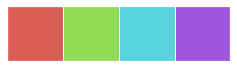

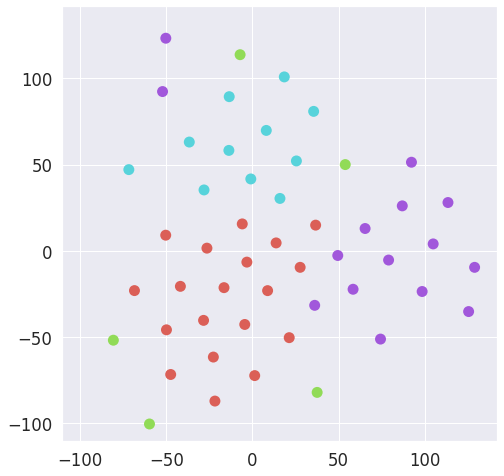

In [52]:
dis=avalues_dense[all_h_list[all_h_list==49],all_t_list[[all_h_list==49]],:].max(1)[1]
users_45=users[47]
u45_items=items[all_t_list[[all_h_list==49]]]
u45_items=torch.stack([u45_items[i,dis[i]*16:dis[i]*16+16] for i in range(u45_items.shape[0])])
item_embedded = TSNE(n_components=2).fit_transform(u45_items)
sns.palplot(np.array(sns.color_palette("hls", 4)))
scatter(item_embedded, dis.numpy())

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x7f6645c46b00>)

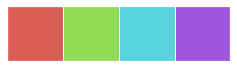

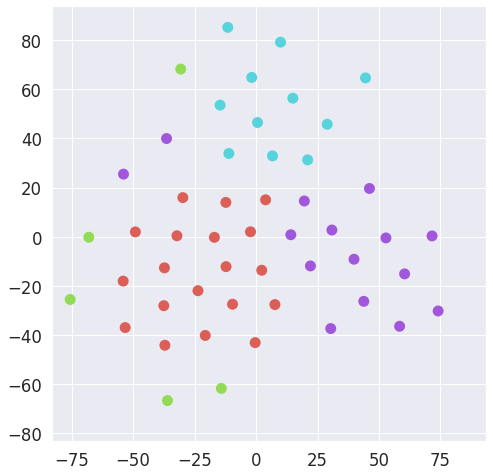

In [53]:
dis=avalues_dense[all_h_list[all_h_list==49],all_t_list[[all_h_list==49]],:].max(1)[1]
users_45=users[47]
u45_items=items[all_t_list[[all_h_list==49]]]
u45_items=torch.stack([u45_items[i,dis[i]*16:dis[i]*16+16] for i in range(u45_items.shape[0])])
item_embedded = TSNE(n_components=2).fit_transform(u45_items)
sns.palplot(np.array(sns.color_palette("hls", 4)))
scatter(item_embedded, dis.numpy())

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x7f6645bca358>)

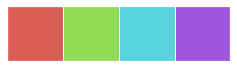

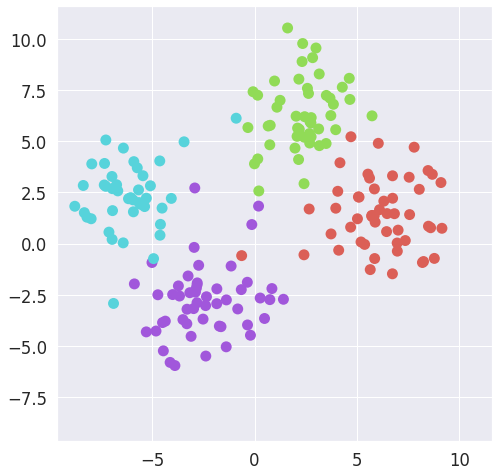

In [54]:
dis=avalues_dense[all_h_list[all_h_list==50],all_t_list[[all_h_list==50]],:].max(1)[1]
users_45=users[47]
u45_items=items[all_t_list[[all_h_list==50]]]
u45_items=torch.stack([u45_items[i,dis[i]*16:dis[i]*16+16] for i in range(u45_items.shape[0])])
item_embedded = TSNE(n_components=2).fit_transform(u45_items)
sns.palplot(np.array(sns.color_palette("hls", 4)))
scatter(item_embedded, dis.numpy())

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x7f6645b2fc18>)

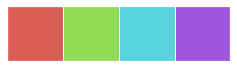

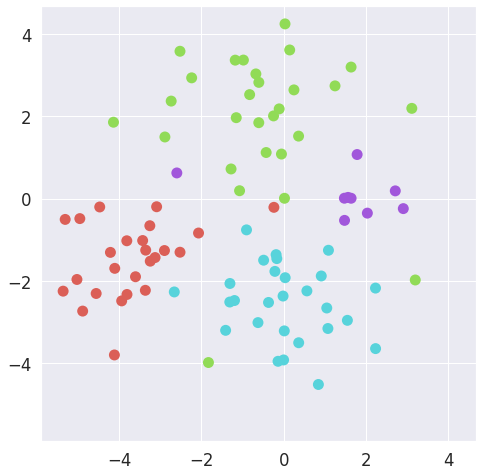

In [56]:
dis=avalues_dense[all_h_list[all_h_list==57],all_t_list[[all_h_list==57]],:].max(1)[1]
users_45=users[47]
u45_items=items[all_t_list[[all_h_list==57]]]
u45_items=torch.stack([u45_items[i,dis[i]*16:dis[i]*16+16] for i in range(u45_items.shape[0])])
item_embedded = TSNE(n_components=2).fit_transform(u45_items)
sns.palplot(np.array(sns.color_palette("hls", 4)))
scatter(item_embedded, dis.numpy())